# **Final Project** 

## **Predicting Popularity and Sentiment of Online News on Social Media**

In [1]:
# import needed libraries
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras import models, layers, regularizers, optimizers, Model
from keras.layers import Dense, Dropout, Activation, Input, LSTM, Embedding, SimpleRNN, GRU, Conv1D, MaxPooling1D 
from keras.regularizers import l2
from tensorflow.keras.preprocessing.text import Tokenizer
from keras.utils.np_utils import to_categorical
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.dummy import DummyClassifier
from sklearn.metrics import classification_report

import re
import string
from nltk.stem import WordNetLemmatizer
# Ignore warnings
import warnings
warnings.filterwarnings("ignore")

## **Import Data** 

In [2]:
# load data 
df = pd.read_csv("data/News_Final.csv")
print("Data shape:",df.shape)
df.head(5)

Data shape: (93239, 11)


,IDLink,Title,Headline,Source,Topic,PublishDate,SentimentTitle,SentimentHeadline,Facebook,GooglePlus,LinkedIn
0,99248.0,Obama Lays Wreath at Arlington National Cemetery,Obama Lays Wreath at Arlington National Cemete...,USA TODAY,obama,2002-04-02 00:00:00,0.000000,-0.053300,-1,-1,-1
1,10423.0,A Look at the Health of the Chinese Economy,"Tim Haywood, investment director business-unit...",Bloomberg,economy,2008-09-20 00:00:00,0.208333,-0.156386,-1,-1,-1
2,18828.0,Nouriel Roubini: Global Economy Not Back to 2008,"Nouriel Roubini, NYU professor and chairman at...",Bloomberg,economy,2012-01-28 00:00:00,-0.425210,0.139754,-1,-1,-1
3,27788.0,Finland GDP Expands In Q4,Finland's economy expanded marginally in the t...,RTT News,economy,2015-03-01 00:06:00,0.000000,0.026064,-1,-1,-1
4,27789.0,"Tourism, govt spending buoys Thai economy in J...",Tourism and public spending continued to boost...,The Nation - Thailand&#39;s English news,economy,2015-03-01 00:11:00,0.000000,0.141084,-1,-1,-1


**Let's explored the data a bit more.**

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 93239 entries, 0 to 93238
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   IDLink             93239 non-null  float64
 1   Title              93239 non-null  object 
 2   Headline           93224 non-null  object 
 3   Source             92960 non-null  object 
 4   Topic              93239 non-null  object 
 5   PublishDate        93239 non-null  object 
 6   SentimentTitle     93239 non-null  float64
 7   SentimentHeadline  93239 non-null  float64
 8   Facebook           93239 non-null  int64  
 9   GooglePlus         93239 non-null  int64  
 10  LinkedIn           93239 non-null  int64  
dtypes: float64(3), int64(3), object(5)
memory usage: 7.8+ MB


In [4]:
df.describe()

,IDLink,SentimentTitle,SentimentHeadline,Facebook,GooglePlus,LinkedIn
count,93239.000000,93239.000000,93239.000000,93239.000000,93239.000000,93239.000000
mean,51560.653257,-0.005411,-0.027493,113.141336,3.888362,16.547957
std,30391.078704,0.136431,0.141964,620.173233,18.492648,154.459048
min,1.000000,-0.950694,-0.755433,-1.000000,-1.000000,-1.000000
25%,24301.500000,-0.079057,-0.114574,0.000000,0.000000,0.000000
50%,52275.000000,0.000000,-0.026064,5.000000,0.000000,0.000000
75%,76585.500000,0.064255,0.059709,33.000000,2.000000,4.000000
max,104802.000000,0.962354,0.964646,49211.000000,1267.000000,20341.000000


## **Data Cleaning and Preprocessing**

**I need to make a popularity feature accorss all the social media networks. This feature will be the sum of the three other social network features i.e. Facebook, Google and Linkedin.  
If a feature sums up to -3, this means that it was not share on any of the social media platforms and is therefore removed from the data.**

In [5]:
df["Popularity"] = df["Facebook"] + df["GooglePlus"] + df["LinkedIn"]
# remove news that is not shared ony any social media
df = df[df['Popularity'] != -3]

In [6]:
df.head(5)

,IDLink,Title,Headline,Source,Topic,PublishDate,SentimentTitle,SentimentHeadline,Facebook,GooglePlus,LinkedIn,Popularity
6,80690.0,"Monday, 29 Feb 2016","RAMALLAH, February 25, 2016 (WAFA) - Palestine...",NaN,palestine,2016-02-28 14:03:00,0.000000,-0.005906,0,0,0,0
56,81052.0,"Monday, 29 Feb 2016","RAMALLAH, February 29, 2016 (WAFA) - The Gover...",NaN,palestine,2016-03-01 09:29:00,0.000000,0.048546,0,0,0,0
111,80994.0,"Tuesday, 1 Mar 2016","RAMALLAH, February 29, 2016 (WAFA) - The Gover...",NaN,palestine,2016-03-01 00:15:00,-0.243068,0.048546,0,0,0,0
726,311.0,Microsoft offering £100 discount on original B...,Just ahead of the market rollout of Microsoft'...,International Business Times via Yahoo UK & Ir...,microsoft,2015-11-08 05:25:00,0.000000,-0.132812,0,0,0,0
727,252.0,Economy to improve though no change in last 6 ...,"&quot;In the coming six months, there seems to...",IANS India Private Limited/Yahoo India News vi...,economy,2015-11-08 05:40:00,-0.082022,0.205537,0,0,0,0


In [7]:
df.shape

(87495, 12)

In [8]:
df.describe()

,IDLink,SentimentTitle,SentimentHeadline,Facebook,GooglePlus,LinkedIn,Popularity
count,87495.000000,87495.000000,87495.000000,87495.000000,87495.000000,87495.000000,87495.000000
mean,51148.167690,-0.005293,-0.027386,120.634653,4.209281,17.699971,142.543905
std,30338.026135,0.136353,0.142069,639.494666,19.046186,159.381025,679.902533
min,1.000000,-0.950694,-0.755433,-1.000000,0.000000,-1.000000,-2.000000
25%,23871.500000,-0.078793,-0.114210,0.000000,0.000000,0.000000,1.000000
50%,51526.000000,0.000000,-0.026064,6.000000,0.000000,0.000000,11.000000
75%,76165.500000,0.065057,0.059963,38.000000,2.000000,4.000000,60.000000
max,104802.000000,0.962354,0.964646,49211.000000,1267.000000,20341.000000,49211.000000


**Convert the numeric variables of sentiment and popularity into categorical variables instead.**

In [9]:
def make_popularity(x):
    if x >= 500: 
        return "popular"
    if x >= 50:
        return "moderate"
    else:
        return "not_popular"
    
df["Popularity"] = df["Popularity"].apply(make_popularity)
df.head(5)

,IDLink,Title,Headline,Source,Topic,PublishDate,SentimentTitle,SentimentHeadline,Facebook,GooglePlus,LinkedIn,Popularity
6,80690.0,"Monday, 29 Feb 2016","RAMALLAH, February 25, 2016 (WAFA) - Palestine...",NaN,palestine,2016-02-28 14:03:00,0.000000,-0.005906,0,0,0,not_popular
56,81052.0,"Monday, 29 Feb 2016","RAMALLAH, February 29, 2016 (WAFA) - The Gover...",NaN,palestine,2016-03-01 09:29:00,0.000000,0.048546,0,0,0,not_popular
111,80994.0,"Tuesday, 1 Mar 2016","RAMALLAH, February 29, 2016 (WAFA) - The Gover...",NaN,palestine,2016-03-01 00:15:00,-0.243068,0.048546,0,0,0,not_popular
726,311.0,Microsoft offering £100 discount on original B...,Just ahead of the market rollout of Microsoft'...,International Business Times via Yahoo UK & Ir...,microsoft,2015-11-08 05:25:00,0.000000,-0.132812,0,0,0,not_popular
727,252.0,Economy to improve though no change in last 6 ...,"&quot;In the coming six months, there seems to...",IANS India Private Limited/Yahoo India News vi...,economy,2015-11-08 05:40:00,-0.082022,0.205537,0,0,0,not_popular


In [10]:
def make_sentiment(x):
    if x > 0:
        return "positive"
    if x < 0: 
        return "negative"
    if x == 0:
        return "neutral"

df["SentimentTitle"] = df["SentimentTitle"].apply(make_sentiment)
df.head(5)

,IDLink,Title,Headline,Source,Topic,PublishDate,SentimentTitle,SentimentHeadline,Facebook,GooglePlus,LinkedIn,Popularity
6,80690.0,"Monday, 29 Feb 2016","RAMALLAH, February 25, 2016 (WAFA) - Palestine...",NaN,palestine,2016-02-28 14:03:00,neutral,-0.005906,0,0,0,not_popular
56,81052.0,"Monday, 29 Feb 2016","RAMALLAH, February 29, 2016 (WAFA) - The Gover...",NaN,palestine,2016-03-01 09:29:00,neutral,0.048546,0,0,0,not_popular
111,80994.0,"Tuesday, 1 Mar 2016","RAMALLAH, February 29, 2016 (WAFA) - The Gover...",NaN,palestine,2016-03-01 00:15:00,negative,0.048546,0,0,0,not_popular
726,311.0,Microsoft offering £100 discount on original B...,Just ahead of the market rollout of Microsoft'...,International Business Times via Yahoo UK & Ir...,microsoft,2015-11-08 05:25:00,neutral,-0.132812,0,0,0,not_popular
727,252.0,Economy to improve though no change in last 6 ...,"&quot;In the coming six months, there seems to...",IANS India Private Limited/Yahoo India News vi...,economy,2015-11-08 05:40:00,negative,0.205537,0,0,0,not_popular


**Check the balance of the data with respect to both variables which are to be predicted.**

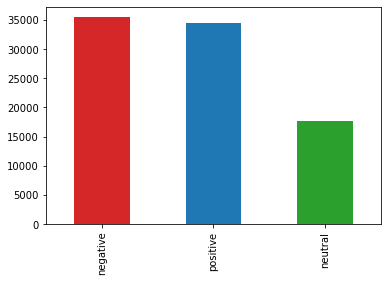

negative    35493
positive    34382
neutral     17620
Name: SentimentTitle, dtype: int64
Total:  87495


In [11]:
sentiment_counts = df["SentimentTitle"].value_counts().to_frame()
sentiment_counts.plot(y="SentimentTitle", kind="bar",color=["C3", "C0", "C2"], legend=False)
plt.show()
print(df["SentimentTitle"].value_counts())
print("Total: ",len(df["SentimentTitle"]))

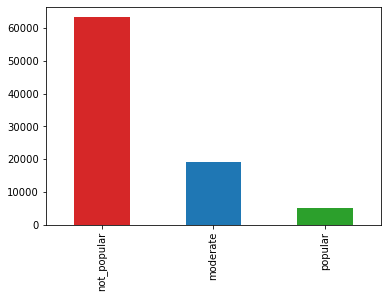

not_popular    63336
moderate       19025
popular         5134
Name: Popularity, dtype: int64
Total:  87495


In [12]:
popularity_counts = df["Popularity"].value_counts().to_frame()
popularity_counts.plot(y="Popularity", kind="bar",color=["C3", "C0", "C2"], legend=False)
plt.show()
print(df["Popularity"].value_counts())
print("Total: ",len(df["Popularity"]))

**Both variables are imbalanced.** 

**Created the final dataframe and reindex the data.**

In [13]:
# take a subset of the data
df = df[["Title", "SentimentTitle", "Popularity"]]
# shuffle data
df = df .reindex(np.random.permutation(df.index))
df.reset_index(inplace = True)

### **Normalisation and noise reduction**

**Lemmatize and clean the news titles data.  Conversion to lowercase and removal of special characters is done with the tokenizer.**  

In [14]:
# instantiate the lemmatizer
lemmatizer = WordNetLemmatizer()

#custom stop words taken from "Performing Sentiment Analysis on Large Email Text Data" by Sandeep Sreehari page 170
stop_words= set([ "the", "i", "me", "my", "myself", "we", "our", "ours", "ourselves", "you", "you're", "you've", "br",\
            "you'll", "you'd", "yours", "yourself", "yourselves", "he", "him", "his", "himself", \
            "she", "she's", "her", "hers", "herself", "it", "it's", "its", "itself", "they", "them", "their",\
            "theirs", "themselves", "what", "which", "who", "whom", "this", "that", "that'll", "these", "those", \
            "am", "is", "are", "was", "were", "be", "been", "being", "have", "has", "had", "having", "do", "does", \
            "did", "doing", "a", "an", "the", "and", "but", "if", "or", "because", "as", "until", "while", "of", \
            "at", "by", "for", "with", "about", "against", "between", "into", "through", "during", "before", "after",\
            "above", "below", "to", "from", "up", "down", "in", "out", "on", "off", "over", "under", "again", "further",\
            "then", "once", "here", "there", "when", "where", "why", "how", "all", "any", "both", "each", "few", "more",\
            "most", "other", "some", "such", "only", "own", "same", "so", "than", "too", \
            "s", "t", "can", "will", "now", "d", "ll", "m", "o", "re", "ve", "y","hadn"])

# remove email like strings
def remove_emails(s):
    return re.sub(r'([a-z0-9+._-]+@[a-z0-9+._-]+\.[a-z0-9+_-]+)'," ", s)

# remove url like strings
def remove_urls(s):
    return re.sub(r'(http|https|ftp|ssh)://([\w_-]+(?:(?:\.[\w_-]+)+))([\w.,@?^=%&:/~+#-]*[\w@?^=%&/~+#-])?', ' ' , s)

# remove special characters
def remove_special_chars(s):
    s = re.sub(r'[^\w ]+', " ", s)
    s = ' '.join(s.split())
    return s

# remove punctuation for a string
def remove_punctuation(s):
    return re.sub(r'[^\w\s]', ' ', s)

# covert string to lower case
def to_lower(s):
    return str(s).lower().replace('\\', '').replace('_', ' ')

#cleans the text
def get_clean_title(s):
    s = remove_emails(s)
    s = remove_urls(s)
    s = to_lower(s)
    s = [lemmatizer.lemmatize(token, "v") for token in s] #Lemmatization
    s = "".join(s)
    s.strip()
    return s

#clean the data
df.loc[:,"Title"] = df.loc[:,"Title"].apply(get_clean_title)

In [15]:
df.head(5)

,index,Title,SentimentTitle,Popularity
0,41931,german economy takes a blow from weakening glo...,negative,not_popular
1,45710,trudeau boosts market-oriented group on clean-...,positive,not_popular
2,70351,microsoft arrow launcher updated with more wun...,neutral,not_popular
3,10121,palestine native adrian peterson wins nfc offe...,negative,not_popular
4,62513,obama praises young indian-american science wi...,negative,not_popular


### **Split the data into train and test sets**

In [16]:
train_data, test_data, train_labels, test_labels = train_test_split(df["Title"], df[["SentimentTitle", "Popularity"]], test_size=0.2)
print("Count of train data samples:", len(train_data))
print("Count of test data samples:" , len(test_data))

Count of train data samples: 69996
Count of test data samples: 17499


### **Tokenisation and encoding**

In [17]:
# number of words variable
NUM_WORDS = 5000
max_sequence_length = 50

tokenizer = Tokenizer(num_words = NUM_WORDS,
               filters = '"#%&()*+,-./:;<=>@[\\]^_`{|}~\t\n',  # dont remove !,?,$
               lower = True,
               split = " ")

# create dictionary 
tokenizer.fit_on_texts(train_data)

In [18]:
# convert list strings to list of number 
train_data_seq = tokenizer.texts_to_sequences(train_data)
test_data_seq = tokenizer.texts_to_sequences(test_data)

In [19]:
# padding data for RNN, lstm and GRU networks
padded_inputs = pad_sequences(train_data_seq, maxlen=max_sequence_length, value = 0.0) # 0.0 because it corresponds with <PAD>
padded_inputs_test = pad_sequences(test_data_seq, maxlen=max_sequence_length, value = 0.0) # 0.0 because it corresponds with <PAD>

In [20]:
# code adapted from DLWP page 69
def vectorize_sequences(sequences, dimension):
    results = np.zeros((len(sequences), dimension))
    for i, sequence in enumerate(sequences):
        results[i, sequence] = 1.
    return results

x_train = vectorize_sequences(train_data_seq,NUM_WORDS)
x_test = vectorize_sequences(test_data_seq,NUM_WORDS)

**In the next cells I encode the data using one hot encoding.**

In [21]:
le = LabelEncoder()

In [22]:
train_labels_le_sentiment = le.fit_transform(train_labels["SentimentTitle"])
test_labels_le_sentiment  = le.transform(test_labels["SentimentTitle"])
one_hot_train_labels_sentiment = to_categorical(train_labels_le_sentiment)
one_hot_test_labels_sentiment  = to_categorical(test_labels_le_sentiment)

In [23]:
train_labels_le_poplarity = le.fit_transform(train_labels["Popularity"])
test_labels_le_popularity = le.transform(test_labels["Popularity"])
one_hot_train_labels_popularity = to_categorical(train_labels_le_poplarity)
one_hot_test_labels_popularity = to_categorical(test_labels_le_popularity)

**Some code to visualise the performance of the models**

In [24]:
#plt.rcParams.update({'figure.figsize':(28,4)})
# code adapted from DLWP page 81
def plot_perfromance(train, val, metric, ax, pred_var):    
    if metric == "loss":
        train_label = "Training Loss"
        val_label = "Validation Loss"
        title = "Training and Validation Loss - " + pred_var
        y_label = "Loss"
    if metric == "precision":
        train_label = "Training Precision"
        val_label = "Validation Precision"
        title = "Training and Validation Precision - " + pred_var
        y_label = "Precision"
    if metric == "recall":
        train_label = "Training recall"
        val_label = "Validation recall"
        title = "Training and Validation Recall - " + pred_var
        y_label = "Recall"
        
    epochs = range(1, len(train) + 1)
    ax.plot(epochs, train, "b", label = train_label, color="blue")
    ax.plot(epochs, val, "b", label = val_label, color="red")
    ax.set_xlabel("Epochs")
    ax.set_ylabel(y_label)
    ax.set_title(title)
    ax.legend()

In [25]:
# https://www.machinelearningplus.com/plots/subplots-python-matplotlib/
def show_perfromances(base_history):
    fig, ((ax1, ax2, ax3),(ax4,ax5,ax6)) = plt.subplots(nrows=2, ncols=3)
    #fig.set_size_inches(24,5)
    fig.set_size_inches(22,10)
    plot_perfromance(base_history.history["sentiment_precision"], base_history.history["val_sentiment_precision"],"precision",ax1, "Sentiment")
    plot_perfromance(base_history.history["sentiment_recall"], base_history.history["val_sentiment_recall"],"recall",ax2, "Sentiment") 
    plot_perfromance(base_history.history["sentiment_loss"], base_history.history["val_sentiment_loss"],"loss",ax3, "Sentiment")

    plot_perfromance(base_history.history["popularity_precision_1"], base_history.history["val_popularity_precision_1"],"precision",ax4, "Popularity")
    plot_perfromance(base_history.history["popularity_recall_1"], base_history.history["val_popularity_recall_1"],"recall",ax5, "Popularity") 
    plot_perfromance(base_history.history["popularity_loss"], base_history.history["val_popularity_loss"],"loss",ax6, "Popularity")
    
    final_loss = base_history.history["val_loss"][len(base_history.history["val_loss"])-1] 
    print("Final model loss on validation data:", str(round(final_loss* 100,2)) + "%")
    
def evaluate_model(model, x_data, y_data_sentiment, y_data_popularity):
    model_eval1 = model.evaluate(x_data, y_data_sentiment)
    print("\nSentiment prediction, performance on validation data:")
    print("model precision:",str(round(model_eval1[3] * 100,2)) + "%"
          "\nmodel recall :",str(round(model_eval1[4] * 100,2)) + "%",
          "\nmodel loss:", str(round(model_eval1[1] * 100,2)) + "%")
    print("========================================================================================================================================\n")
    model_eval2 = model.evaluate(x_data, y_data_popularity)
    print("\nPopularity prediction, performance on validation data:")
    print("model precision:",str(round(model_eval2[5] * 100,2)) + "%"
          "\nmodel recall :",str(round(model_eval2[6] * 100,2)) + "%",
          "\nmodel loss:", str(round(model_eval2[2] * 100,2)) + "%")

## **Developing the Model**

### **Base model - Feed Forward Model**

**Function to create base model - feed forward network with 3 dense layers. Other parameters:**  
**- Relu activation for the hidden layers**  
**- Softmax activation for the output layers**  
**- Optimizer is rmsprop**  
**- Loss function is categorical_crossentropy for both predicted variables**  
**- Metrics are precision and recall**

In [26]:
def create_model(input_shape, neurons_first=64, neurons_second=46, neurons_third=32) :
    main_input = Input(shape=(input_shape,), dtype='int32', name='main_input')
    x = Dense(neurons_first, activation="relu") (main_input)
    x = Dense(neurons_second, activation='relu')(x)
    x = Dense(neurons_third, activation='relu')(x)
    sentiment_predcition = Dense(3, activation='softmax', name="sentiment")(x)
    popularity_prediction = Dense(3, activation='softmax', name="popularity")(x)
    model = Model(inputs=main_input, outputs=[sentiment_predcition, popularity_prediction], name = "base_network", )
    model.compile(optimizer="rmsprop",
              loss={"sentiment":"categorical_crossentropy", "popularity":"categorical_crossentropy"},
              metrics=["Precision", "Recall"])
    return model

# create the model
FF_model = create_model(NUM_WORDS)
FF_model.summary()

Model: "base_network"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 main_input (InputLayer)        [(None, 5000)]       0           []                               
                                                                                                  
 dense (Dense)                  (None, 64)           320064      ['main_input[0][0]']             
                                                                                                  
 dense_1 (Dense)                (None, 46)           2990        ['dense[0][0]']                  
                                                                                                  
 dense_2 (Dense)                (None, 32)           1504        ['dense_1[0][0]']                
                                                                                       

**Train the model and show its performance.**

In [27]:
FF_history = FF_model.fit(x_train, 
                         [one_hot_train_labels_sentiment, one_hot_train_labels_popularity],
                         epochs=15, 
                         batch_size=512,
                         validation_data=(x_test, [one_hot_test_labels_sentiment,one_hot_test_labels_popularity]),
                         verbose=0)

Final model loss on validation data: 147.51%


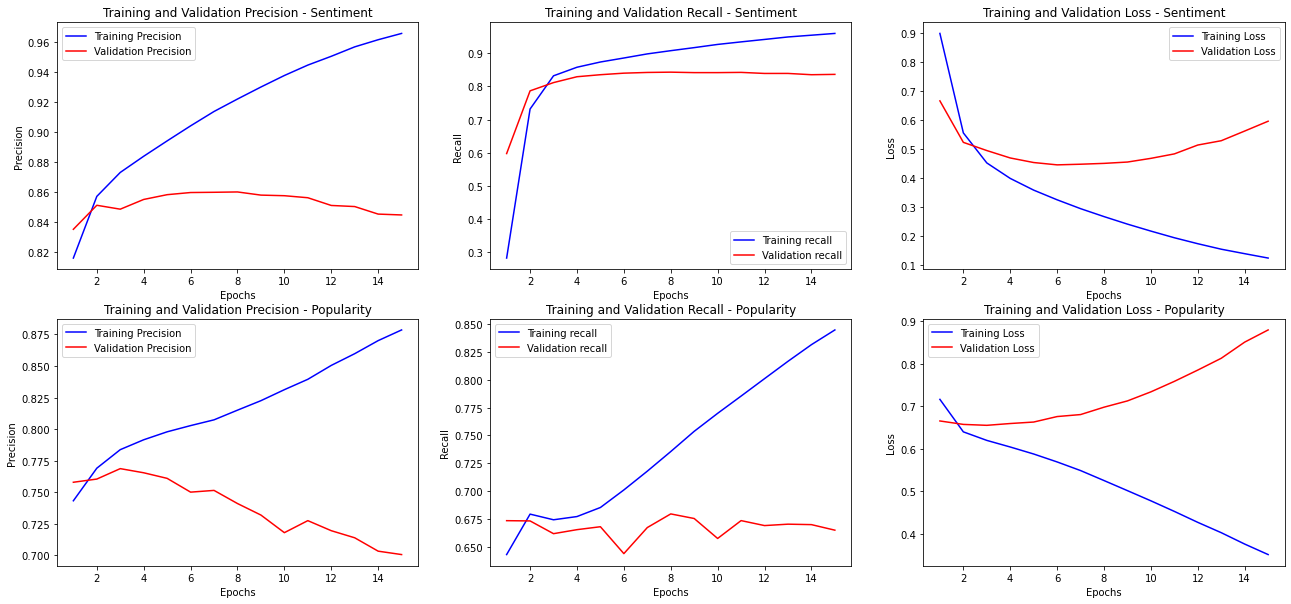

In [28]:
show_perfromances(FF_history)

In [29]:
evaluate_model(FF_model, x_test,one_hot_test_labels_sentiment,one_hot_test_labels_popularity)

547/547 [==============================] - 2s 2ms/step - loss: 4.0511 - sentiment_loss: 0.5960 - popularity_loss: 3.4552 - sentiment_precision: 0.8449 - sentiment_recall: 0.8366 - popularity_precision_1: 0.2504 - popularity_recall_1: 0.2377

Sentiment prediction, performance on validation data:
model precision: 84.49%
model recall : 83.66% 
model loss: 59.6%

547/547 [==============================] - 1s 2ms/step - loss: 5.9019 - sentiment_loss: 5.0227 - popularity_loss: 0.8791 - sentiment_precision: 0.2564 - sentiment_recall: 0.2538 - popularity_precision_1: 0.7005 - popularity_recall_1: 0.6651

Popularity prediction, performance on validation data:
model precision: 70.05%
model recall : 66.51% 
model loss: 87.91%


**We can see the base model overfit fast, let’s make it smaller.**

### **Smaller Feed Forward Model**

In [30]:
FF_smaller = create_model(NUM_WORDS,32,16,8)
FF_smaller.summary()

Model: "base_network"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 main_input (InputLayer)        [(None, 5000)]       0           []                               
                                                                                                  
 dense_3 (Dense)                (None, 32)           160032      ['main_input[0][0]']             
                                                                                                  
 dense_4 (Dense)                (None, 16)           528         ['dense_3[0][0]']                
                                                                                                  
 dense_5 (Dense)                (None, 8)            136         ['dense_4[0][0]']                
                                                                                       

**Train the model and show its performance.**

In [31]:
FF_smaller_history = FF_smaller.fit(x_train, 
                         [one_hot_train_labels_sentiment, one_hot_train_labels_popularity],
                         epochs=15, 
                         batch_size=512,
                         validation_data=(x_test, [one_hot_test_labels_sentiment,one_hot_test_labels_popularity]),
                         verbose=0)

Final model loss on validation data: 120.44%


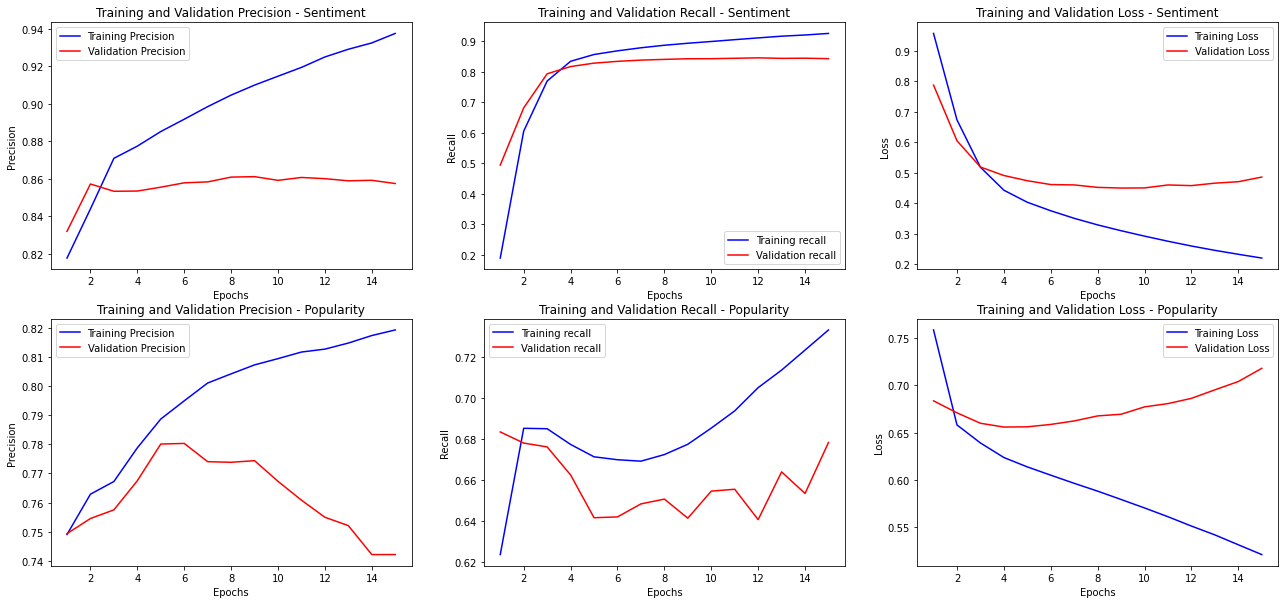

In [32]:
show_perfromances(FF_smaller_history)

In [33]:
evaluate_model(FF_smaller,x_test,one_hot_test_labels_sentiment,one_hot_test_labels_popularity)

547/547 [==============================] - 1s 2ms/step - loss: 3.3768 - sentiment_loss: 0.4864 - popularity_loss: 2.8904 - sentiment_precision: 0.8575 - sentiment_recall: 0.8428 - popularity_precision_1: 0.2206 - popularity_recall_1: 0.2017

Sentiment prediction, performance on validation data:
model precision: 85.75%
model recall : 84.28% 
model loss: 48.64%

547/547 [==============================] - 1s 2ms/step - loss: 4.5083 - sentiment_loss: 3.7903 - popularity_loss: 0.7180 - sentiment_precision: 0.2609 - sentiment_recall: 0.2565 - popularity_precision_1: 0.7422 - popularity_recall_1: 0.6785

Popularity prediction, performance on validation data:
model precision: 74.22%
model recall : 67.85% 
model loss: 71.8%


**Smaller model overfits less and has good performance**

### **Compare RNN, LSTM and GRU Models**

### **RNN Model** 

**Function to create RNN model - feed forward network with 1 Embedding layer and 2 SimpleRNN layers. Other parameters:**  
**- Embedding layer output dimentions = 32**   
**- Relu activation for the hidden layers**  
**- Softmax activation for the output layers**  
**- Optimizer is rmsprop**  
**- Loss function is categorical_crossentropy for both predicted variables**  
**- Metrics are precision and recall** 

In [34]:
embedding_output_dims = 32
def create_RRN_model(NUM_WORDS):
    main_input = Input(shape=(None,), dtype='int32', name='news_input')
    x = Embedding(NUM_WORDS, embedding_output_dims, input_length=max_sequence_length) (main_input)
    x = SimpleRNN(16, return_sequences=True, activation="relu") (x)
    x = SimpleRNN(16, activation="relu") (x)
    x = Dense(8, activation='relu')(x)
    sentiment_predcition = Dense(3, activation='softmax', name="sentiment")(x)
    popularity_prediction = Dense(3, activation='softmax', name="popularity")(x)

    model = Model(inputs=main_input, outputs=[sentiment_predcition, popularity_prediction], name = "rnn_network")
    model.compile(optimizer="rmsprop",
              loss={"sentiment":"categorical_crossentropy", "popularity":"categorical_crossentropy"},
              metrics=["Precision", "Recall"])
    return model

In [35]:
RNN_model = create_RRN_model(NUM_WORDS)
RNN_model.summary()

Model: "rnn_network"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 news_input (InputLayer)        [(None, None)]       0           []                               
                                                                                                  
 embedding (Embedding)          (None, None, 32)     160000      ['news_input[0][0]']             
                                                                                                  
 simple_rnn (SimpleRNN)         (None, None, 16)     784         ['embedding[0][0]']              
                                                                                                  
 simple_rnn_1 (SimpleRNN)       (None, 16)           528         ['simple_rnn[0][0]']             
                                                                                        

**Train the model and show its performance.**

In [36]:
RNN_history = RNN_model.fit(padded_inputs, 
                         [one_hot_train_labels_sentiment, one_hot_train_labels_popularity],
                          batch_size=512, 
                          epochs=15, 
                          verbose=0, 
                          validation_data=(padded_inputs_test, [one_hot_test_labels_sentiment,one_hot_test_labels_popularity]))

Final model loss on validation data: 115.83%


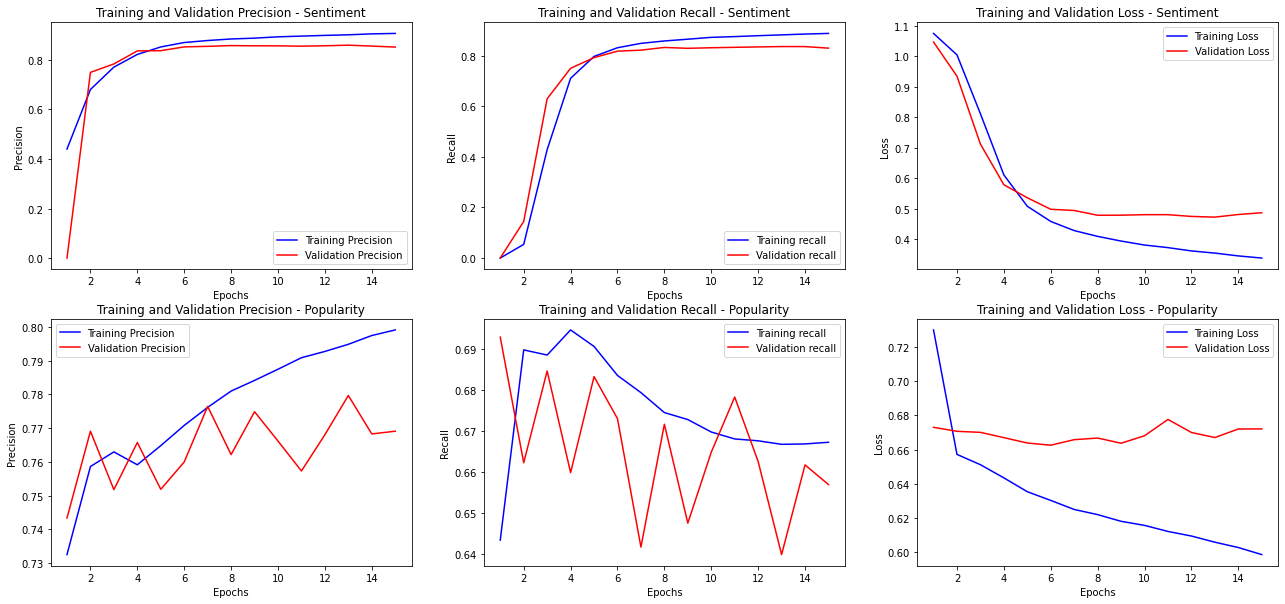

In [37]:
show_perfromances(RNN_history)

In [38]:
evaluate_model(RNN_model, padded_inputs_test, one_hot_test_labels_sentiment, one_hot_test_labels_popularity)

547/547 [==============================] - 4s 5ms/step - loss: 2.8982 - sentiment_loss: 0.4863 - popularity_loss: 2.4120 - sentiment_precision: 0.8516 - sentiment_recall: 0.8298 - popularity_precision_1: 0.2042 - popularity_recall_1: 0.1744

Sentiment prediction, performance on validation data:
model precision: 85.16%
model recall : 82.98% 
model loss: 48.63%

547/547 [==============================] - 2s 4ms/step - loss: 3.4582 - sentiment_loss: 2.7861 - popularity_loss: 0.6720 - sentiment_precision: 0.2520 - sentiment_recall: 0.2455 - popularity_precision_1: 0.7691 - popularity_recall_1: 0.6569

Popularity prediction, performance on validation data:
model precision: 76.91%
model recall : 65.69% 
model loss: 67.2%


### **LSTM Model** 

**Function to create LSTM model - exactly the same as the function that creates the RNN model but with LSTM layers instead.**

In [39]:
embedding_output_dims = 32
def create_lstm_model(NUM_WORDS):
    main_input = Input(shape=(None,), dtype='int32', name='news_input')
    x = Embedding(NUM_WORDS, embedding_output_dims, input_length=max_sequence_length) (main_input)
    x = LSTM(16, return_sequences=True, activation="relu") (x)
    x = LSTM(16, activation="relu") (x)
    x = Dense(8, activation='relu')(x)
    sentiment_predcition = Dense(3, activation='softmax', name="sentiment")(x)
    popularity_prediction = Dense(3, activation='softmax', name="popularity")(x)

    model = Model(inputs=main_input, outputs=[sentiment_predcition, popularity_prediction], name = "lstm_network")
    model.compile(optimizer="rmsprop",
              loss={"sentiment":"categorical_crossentropy", "popularity":"categorical_crossentropy"},
              metrics=["Precision", "Recall"])
    return model

In [40]:
lstm_model = create_lstm_model(NUM_WORDS)
lstm_model.summary()

Model: "lstm_network"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 news_input (InputLayer)        [(None, None)]       0           []                               
                                                                                                  
 embedding_1 (Embedding)        (None, None, 32)     160000      ['news_input[0][0]']             
                                                                                                  
 lstm (LSTM)                    (None, None, 16)     3136        ['embedding_1[0][0]']            
                                                                                                  
 lstm_1 (LSTM)                  (None, 16)           2112        ['lstm[0][0]']                   
                                                                                       

**Train the model and show its performance.**

In [41]:
lstm_history = lstm_model.fit(padded_inputs, 
                         [one_hot_train_labels_sentiment, one_hot_train_labels_popularity],
                          batch_size=512, 
                          epochs=15, 
                          verbose=0, 
                          validation_data=(padded_inputs_test, [one_hot_test_labels_sentiment,one_hot_test_labels_popularity]))

Final model loss on validation data: 113.54%


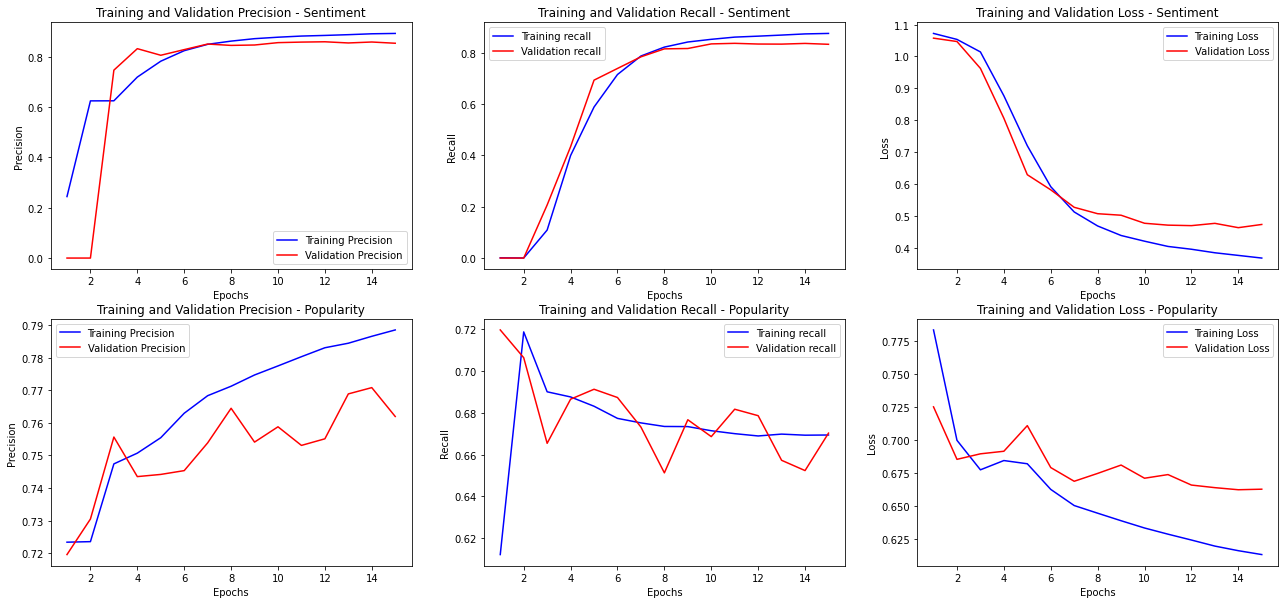

In [42]:
show_perfromances(lstm_history)

In [43]:
evaluate_model(lstm_model, padded_inputs_test, one_hot_test_labels_sentiment, one_hot_test_labels_popularity)

547/547 [==============================] - 4s 6ms/step - loss: 2.7621 - sentiment_loss: 0.4725 - popularity_loss: 2.2896 - sentiment_precision: 0.8542 - sentiment_recall: 0.8330 - popularity_precision_1: 0.2048 - popularity_recall_1: 0.1801

Sentiment prediction, performance on validation data:
model precision: 85.42%
model recall : 83.3% 
model loss: 47.25%

547/547 [==============================] - 3s 6ms/step - loss: 3.1663 - sentiment_loss: 2.5034 - popularity_loss: 0.6628 - sentiment_precision: 0.2504 - sentiment_recall: 0.2442 - popularity_precision_1: 0.7620 - popularity_recall_1: 0.6702

Popularity prediction, performance on validation data:
model precision: 76.2%
model recall : 67.02% 
model loss: 66.28%


### **GRU Model** 

**Function to create GRU model - the same as the function that creates the RNN model but with GRU layers instead.**

In [44]:
embedding_output_dims = 32
def create_gru_model(NUM_WORDS):
    main_input = Input(shape=(None,), dtype='int32', name='news_input')
    x = Embedding(NUM_WORDS, embedding_output_dims, input_length=max_sequence_length) (main_input)
    x = GRU(16, return_sequences=True, activation="relu") (x)
    x = GRU(16, activation="relu") (x)
    x = Dense(8, activation='relu')(x)
    sentiment_predcition = Dense(3, activation='softmax', name="sentiment")(x)
    popularity_prediction = Dense(3, activation='softmax', name="popularity")(x)

    model = Model(inputs=main_input, outputs=[sentiment_predcition, popularity_prediction], name = "gru_network", )
    model.compile(optimizer="rmsprop",
              loss={"sentiment":"categorical_crossentropy", "popularity":"categorical_crossentropy"},
              metrics=["Precision", "Recall"])
    return model 

In [45]:
gru_model = create_gru_model(NUM_WORDS)
gru_model.summary()

Model: "gru_network"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 news_input (InputLayer)        [(None, None)]       0           []                               
                                                                                                  
 embedding_2 (Embedding)        (None, None, 32)     160000      ['news_input[0][0]']             
                                                                                                  
 gru (GRU)                      (None, None, 16)     2400        ['embedding_2[0][0]']            
                                                                                                  
 gru_1 (GRU)                    (None, 16)           1632        ['gru[0][0]']                    
                                                                                        

**Train the model and show its performance.**

In [46]:
gru_history = gru_model.fit(padded_inputs, 
                         [one_hot_train_labels_sentiment, one_hot_train_labels_popularity],
                          batch_size=512, 
                          epochs=15, 
                          verbose=0, 
                          validation_data=(padded_inputs_test, [one_hot_test_labels_sentiment,one_hot_test_labels_popularity]))

Final model loss on validation data: 113.16%


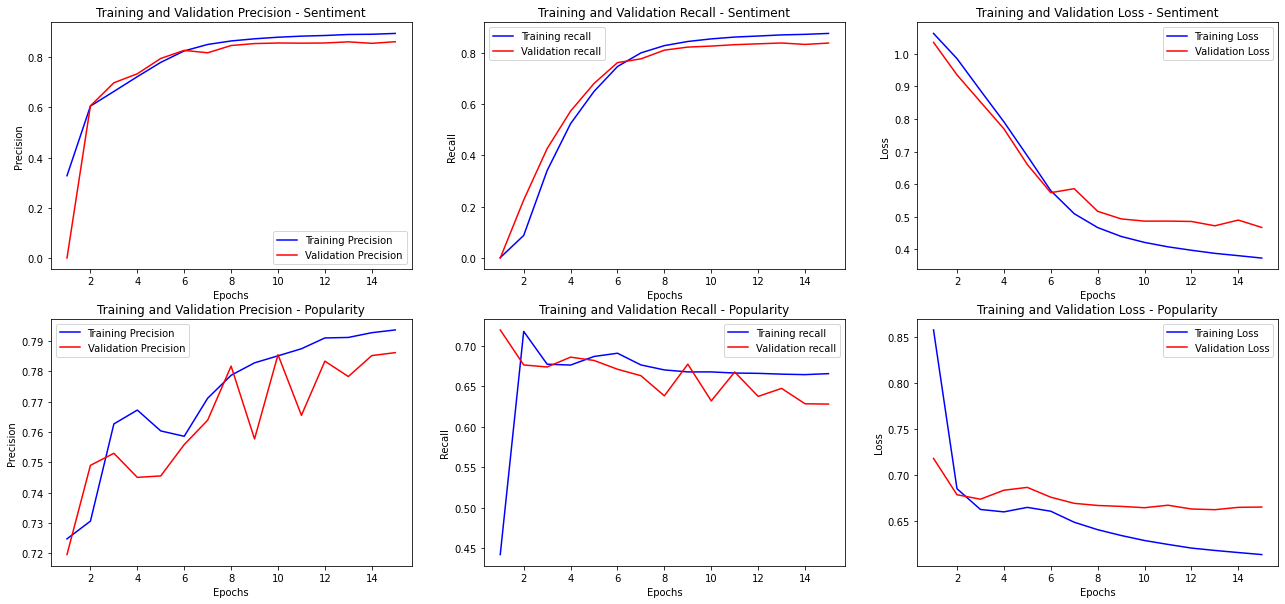

In [47]:
show_perfromances(gru_history)

In [48]:
evaluate_model(gru_model, padded_inputs_test, one_hot_test_labels_sentiment, one_hot_test_labels_popularity)

547/547 [==============================] - 4s 6ms/step - loss: 2.6019 - sentiment_loss: 0.4668 - popularity_loss: 2.1351 - sentiment_precision: 0.8613 - sentiment_recall: 0.8380 - popularity_precision_1: 0.2115 - popularity_recall_1: 0.1689

Sentiment prediction, performance on validation data:
model precision: 86.13%
model recall : 83.8% 
model loss: 46.68%

547/547 [==============================] - 4s 6ms/step - loss: 3.3226 - sentiment_loss: 2.6579 - popularity_loss: 0.6648 - sentiment_precision: 0.2512 - sentiment_recall: 0.2444 - popularity_precision_1: 0.7862 - popularity_recall_1: 0.6280

Popularity prediction, performance on validation data:
model precision: 78.62%
model recall : 62.8% 
model loss: 66.48%


**GRU model has the best performance so I choose to work with it going forward and I proceed to optimise it.** 

### **Turning Hyperparameters on Best Performing Model**

**In the following cells I perform hyperparameter tuning on the GRU model. I experiment with:**  
**1. Reducing the output dimensions of the embedding layer of the network.**  
**2. Performing L2 regularisation with different values.**   
**3. Performing dropout regularisation with different values.**   


### **Architecture optimisation**

**Same function that creates the GRU model but with reduced number of output dimensions(16) for the embedding layer.**

In [49]:
embedding_output_dims = 16
def create_gru_model_arch_opt(NUM_WORDS):
    main_input = Input(shape=(None,), dtype='int32', name='news_input')
    x = Embedding(NUM_WORDS, embedding_output_dims, input_length=max_sequence_length) (main_input)
    x = GRU(16, return_sequences=True) (x)
    x = GRU(16) (x)
    x = Dense(8, activation='relu')(x)
    sentiment_predcition = Dense(3, activation='softmax', name="sentiment")(x)
    popularity_prediction = Dense(3, activation='softmax', name="popularity")(x)

    model = Model(inputs=main_input, outputs=[sentiment_predcition, popularity_prediction], name = "gru_network")
    model.compile(optimizer="rmsprop",
              loss={"sentiment":"categorical_crossentropy", "popularity":"categorical_crossentropy"},
              metrics=["Precision", "Recall"])
    return model

gru_model = create_gru_model_arch_opt(NUM_WORDS)
gru_model.summary()

Model: "gru_network"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 news_input (InputLayer)        [(None, None)]       0           []                               
                                                                                                  
 embedding_3 (Embedding)        (None, None, 16)     80000       ['news_input[0][0]']             
                                                                                                  
 gru_2 (GRU)                    (None, None, 16)     1632        ['embedding_3[0][0]']            
                                                                                                  
 gru_3 (GRU)                    (None, 16)           1632        ['gru_2[0][0]']                  
                                                                                        

In [50]:
gru_history = gru_model.fit(padded_inputs, 
                         [one_hot_train_labels_sentiment, one_hot_train_labels_popularity],
                          batch_size=512, 
                          epochs=15, 
                          verbose=0, 
                          validation_data=(padded_inputs_test, [one_hot_test_labels_sentiment,one_hot_test_labels_popularity]))

Final model loss on validation data: 113.62%


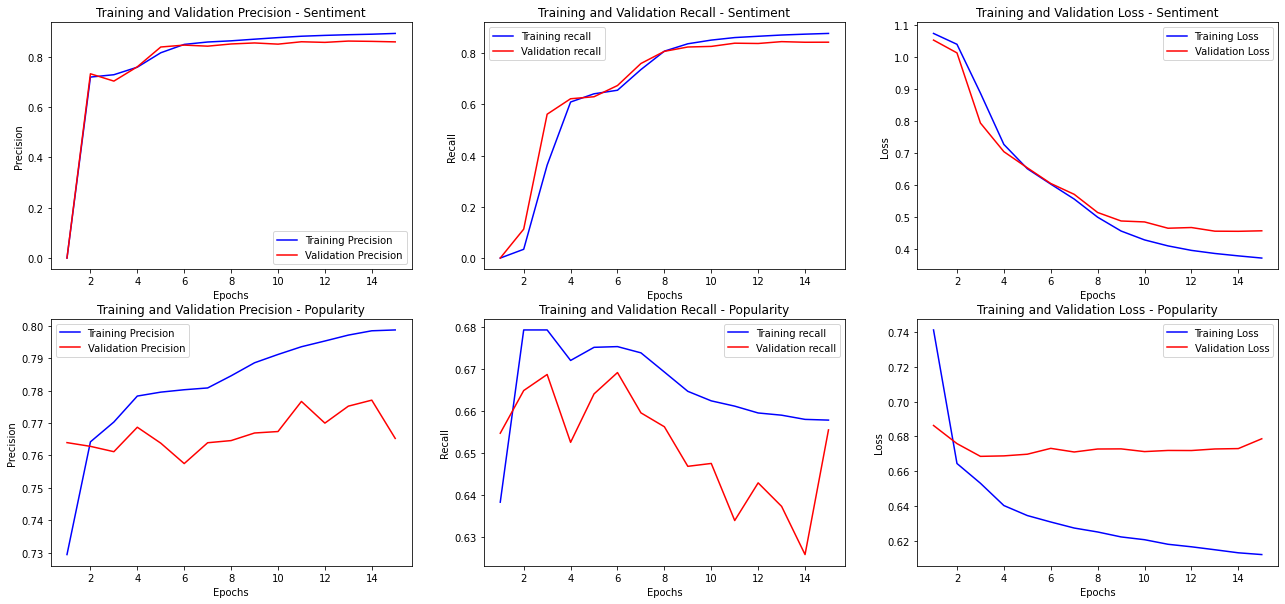

In [51]:
show_perfromances(gru_history)

In [52]:
evaluate_model(gru_model, padded_inputs_test, one_hot_test_labels_sentiment, one_hot_test_labels_popularity)

547/547 [==============================] - 4s 5ms/step - loss: 2.8338 - sentiment_loss: 0.4575 - popularity_loss: 2.3762 - sentiment_precision: 0.8596 - sentiment_recall: 0.8419 - popularity_precision_1: 0.2049 - popularity_recall_1: 0.1756

Sentiment prediction, performance on validation data:
model precision: 85.96%
model recall : 84.19% 
model loss: 45.75%

547/547 [==============================] - 3s 5ms/step - loss: 3.3609 - sentiment_loss: 2.6822 - popularity_loss: 0.6787 - sentiment_precision: 0.2450 - sentiment_recall: 0.2400 - popularity_precision_1: 0.7652 - popularity_recall_1: 0.6555

Popularity prediction, performance on validation data:
model precision: 76.52%
model recall : 65.55% 
model loss: 67.87%


**Having a smaller network due to a reduced number of output dimensions improved the overfitting problem.**

### **Regularisation optimisation**

Same model as before but with added L2 regularisation for the embedding and first GRU layers. Experiment with L2 values of 0.001, 0.0001 and 0.00001

In [53]:
embedding_output_dims = 32
def create_gru_model_reg_opt(NUM_WORDS,l2_rate):
    main_input = Input(shape=(None,), dtype='int32', name='news_input')
    x = Embedding(NUM_WORDS, embedding_output_dims, input_length=max_sequence_length, embeddings_regularizer = l2(l2_rate)) (main_input)
    x = GRU(16, return_sequences=True, kernel_regularizer=regularizers.l2(l2_rate)) (x)
    x = GRU(16) (x)
    x = Dense(8) (x)
    sentiment_predcition = Dense(3, activation='softmax', name="sentiment")(x)
    popularity_prediction = Dense(3, activation='softmax', name="popularity")(x)

    model = Model(inputs=main_input, outputs=[sentiment_predcition, popularity_prediction], name = "gru_network")
    model.compile(optimizer="rmsprop",
              loss={"sentiment":"categorical_crossentropy", "popularity":"categorical_crossentropy"},
              metrics=["Precision", "Recall"])
    return model


gru_model_reg1 = create_gru_model_reg_opt(NUM_WORDS,0.001)
gru_model_reg2 = create_gru_model_reg_opt(NUM_WORDS,0.0001)
gru_model_reg3 = create_gru_model_reg_opt(NUM_WORDS,0.00001)

In [54]:
gru_history_reg1 = gru_model_reg1.fit(padded_inputs, 
                         [one_hot_train_labels_sentiment, one_hot_train_labels_popularity],
                          batch_size=512, 
                          epochs=15, 
                          verbose=0, 
                          validation_data=(padded_inputs_test, [one_hot_test_labels_sentiment,one_hot_test_labels_popularity]))

Final model loss on validation data: 119.89%


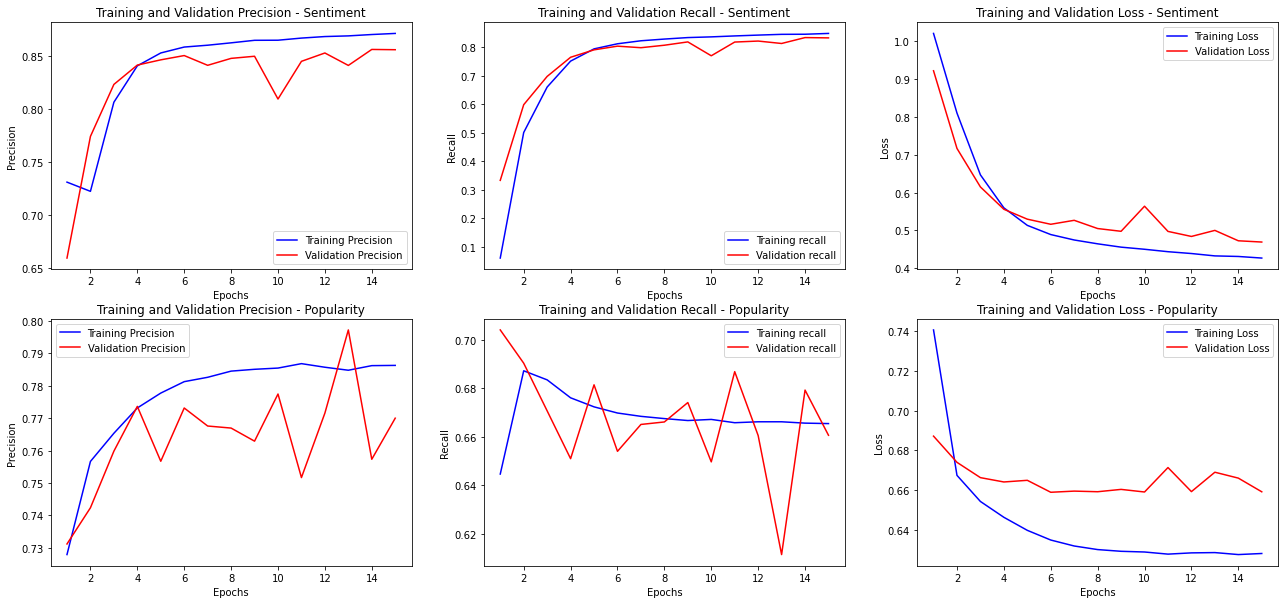

In [55]:
show_perfromances(gru_history_reg1)

In [56]:
evaluate_model(gru_model_reg1, padded_inputs_test, one_hot_test_labels_sentiment, one_hot_test_labels_popularity)

547/547 [==============================] - 5s 6ms/step - loss: 2.7401 - sentiment_loss: 0.4692 - popularity_loss: 2.2004 - sentiment_precision: 0.8558 - sentiment_recall: 0.8332 - popularity_precision_1: 0.2047 - popularity_recall_1: 0.1757

Sentiment prediction, performance on validation data:
model precision: 85.58%
model recall : 83.32% 
model loss: 46.92%

547/547 [==============================] - 3s 6ms/step - loss: 3.2451 - sentiment_loss: 2.5154 - popularity_loss: 0.6592 - sentiment_precision: 0.2552 - sentiment_recall: 0.2485 - popularity_precision_1: 0.7700 - popularity_recall_1: 0.6607

Popularity prediction, performance on validation data:
model precision: 77.0%
model recall : 66.07% 
model loss: 65.92%


In [57]:
gru_history_reg2 = gru_model_reg2.fit(padded_inputs, 
                         [one_hot_train_labels_sentiment, one_hot_train_labels_popularity],
                          batch_size=512, 
                          epochs=15, 
                          verbose=0, 
                          validation_data=(padded_inputs_test, [one_hot_test_labels_sentiment,one_hot_test_labels_popularity]))

Final model loss on validation data: 116.42%


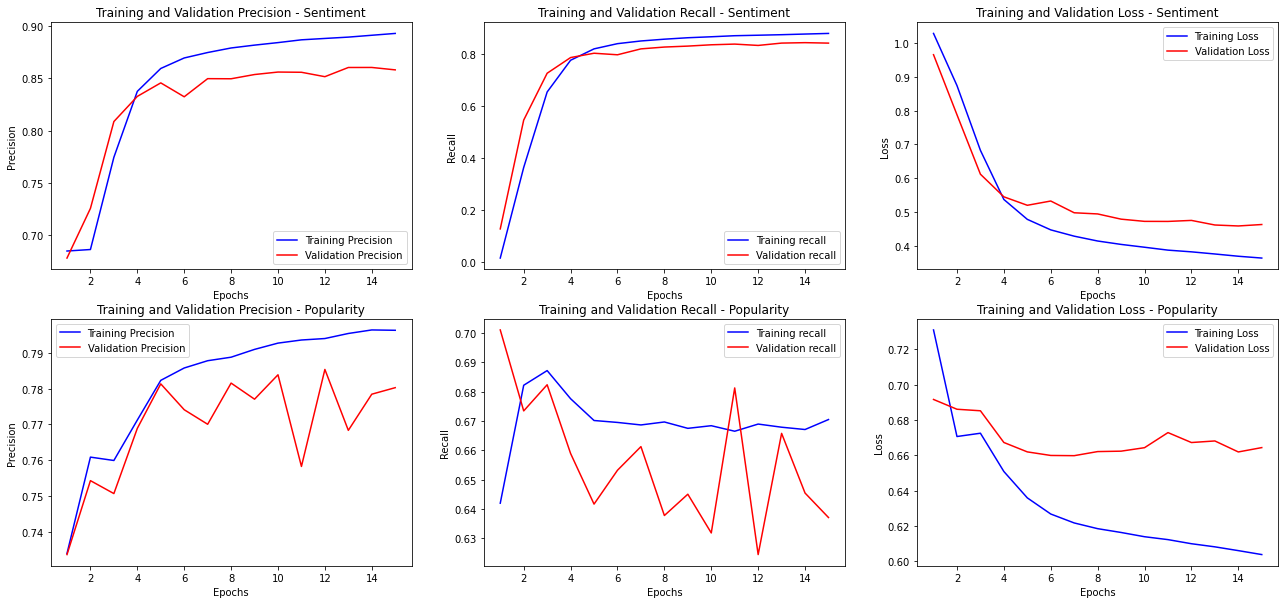

In [58]:
show_perfromances(gru_history_reg2)

In [59]:
evaluate_model(gru_model_reg2, padded_inputs_test, one_hot_test_labels_sentiment, one_hot_test_labels_popularity)

547/547 [==============================] - 4s 6ms/step - loss: 2.6598 - sentiment_loss: 0.4638 - popularity_loss: 2.1599 - sentiment_precision: 0.8581 - sentiment_recall: 0.8414 - popularity_precision_1: 0.2134 - popularity_recall_1: 0.1742

Sentiment prediction, performance on validation data:
model precision: 85.81%
model recall : 84.14% 
model loss: 46.38%

547/547 [==============================] - 3s 6ms/step - loss: 3.2369 - sentiment_loss: 2.5364 - popularity_loss: 0.6643 - sentiment_precision: 0.2514 - sentiment_recall: 0.2465 - popularity_precision_1: 0.7802 - popularity_recall_1: 0.6371

Popularity prediction, performance on validation data:
model precision: 78.02%
model recall : 63.71% 
model loss: 66.43%


In [60]:
gru_history_reg3 = gru_model_reg3.fit(padded_inputs, 
                         [one_hot_train_labels_sentiment, one_hot_train_labels_popularity],
                          batch_size=512, 
                          epochs=15, 
                          verbose=0, 
                          validation_data=(padded_inputs_test, [one_hot_test_labels_sentiment,one_hot_test_labels_popularity]))

Final model loss on validation data: 115.28%


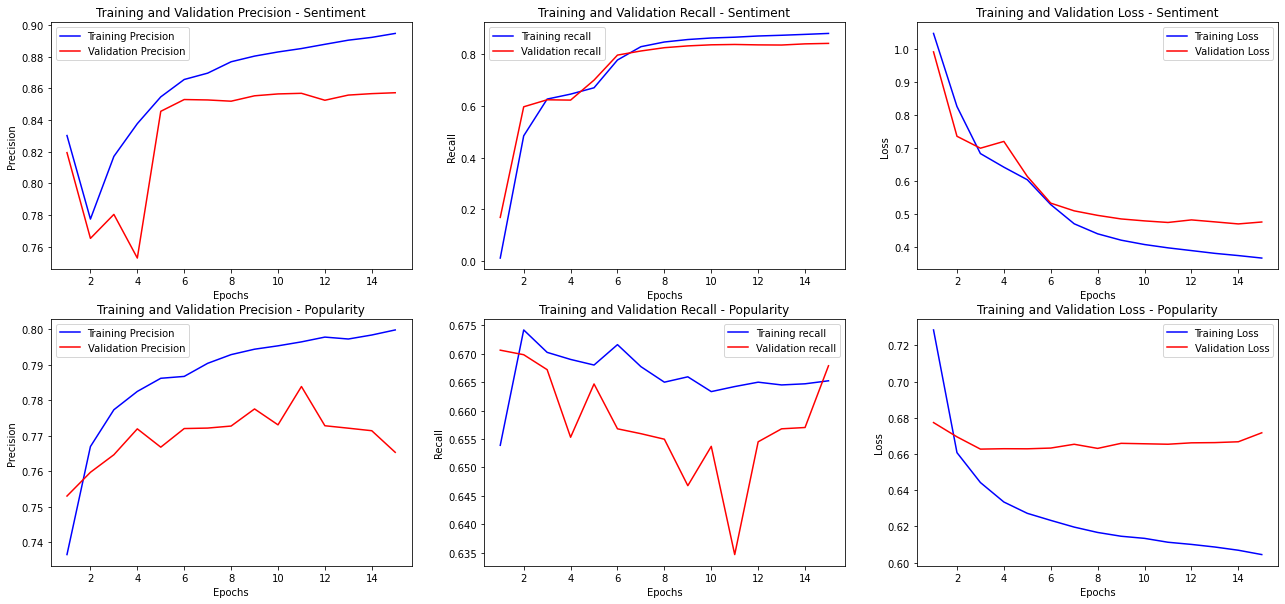

In [61]:
show_perfromances(gru_history_reg3)

In [62]:
evaluate_model(gru_model_reg3, padded_inputs_test, one_hot_test_labels_sentiment, one_hot_test_labels_popularity)

547/547 [==============================] - 5s 6ms/step - loss: 2.9616 - sentiment_loss: 0.4751 - popularity_loss: 2.4805 - sentiment_precision: 0.8572 - sentiment_recall: 0.8415 - popularity_precision_1: 0.2050 - popularity_recall_1: 0.1789

Sentiment prediction, performance on validation data:
model precision: 85.72%
model recall : 84.15% 
model loss: 47.51%

547/547 [==============================] - 3s 6ms/step - loss: 3.3205 - sentiment_loss: 2.6428 - popularity_loss: 0.6717 - sentiment_precision: 0.2621 - sentiment_recall: 0.2573 - popularity_precision_1: 0.7653 - popularity_recall_1: 0.6679

Popularity prediction, performance on validation data:
model precision: 76.53%
model recall : 66.79% 
model loss: 67.17%


**Low L2 Regularisation value of 0.0001 or 0.0001 helps reduce overfitting**

### **Dropout optimisation**

**I add dropout after the embedding and GRU layers. I experiment with dropout rates of 0.2, 0.3 and 0.4.**

In [63]:
embedding_output_dims = 32
def create_gru_model_drop(NUM_WORDS,dropout_rate):
    main_input = Input(shape=(None,), dtype='int32', name='news_input')
    x = Embedding(NUM_WORDS, embedding_output_dims, input_length=max_sequence_length) (main_input)
    x = Dropout(dropout_rate) (x)
    x = GRU(16, return_sequences=True) (x)
    x = Dropout(dropout_rate) (x)
    x = GRU(16) (x) 
    x = Dropout(dropout_rate) (x)
    x = Dense(8, activation='relu')(x)
    sentiment_predcition = Dense(3, activation='softmax', name="sentiment")(x)
    popularity_prediction = Dense(3, activation='softmax', name="popularity")(x)

    model = Model(inputs=main_input, outputs=[sentiment_predcition, popularity_prediction], name = "gru_network")
    model.compile(optimizer="rmsprop",
              loss={"sentiment":"categorical_crossentropy", "popularity":"categorical_crossentropy"},
              metrics=["Precision", "Recall"])
    return model

gru_model_drop1 = create_gru_model_drop(NUM_WORDS,0.2)
gru_model_drop2  = create_gru_model_drop(NUM_WORDS,0.3)
gru_model_drop3  = create_gru_model_drop(NUM_WORDS,0.4)

In [64]:
gru_history_drop1 = gru_model_drop1.fit(padded_inputs, 
                         [one_hot_train_labels_sentiment, one_hot_train_labels_popularity],
                          batch_size=512, 
                          epochs=15, 
                          verbose=0, 
                          validation_data=(padded_inputs_test, [one_hot_test_labels_sentiment,one_hot_test_labels_popularity]))

Final model loss on validation data: 111.74%


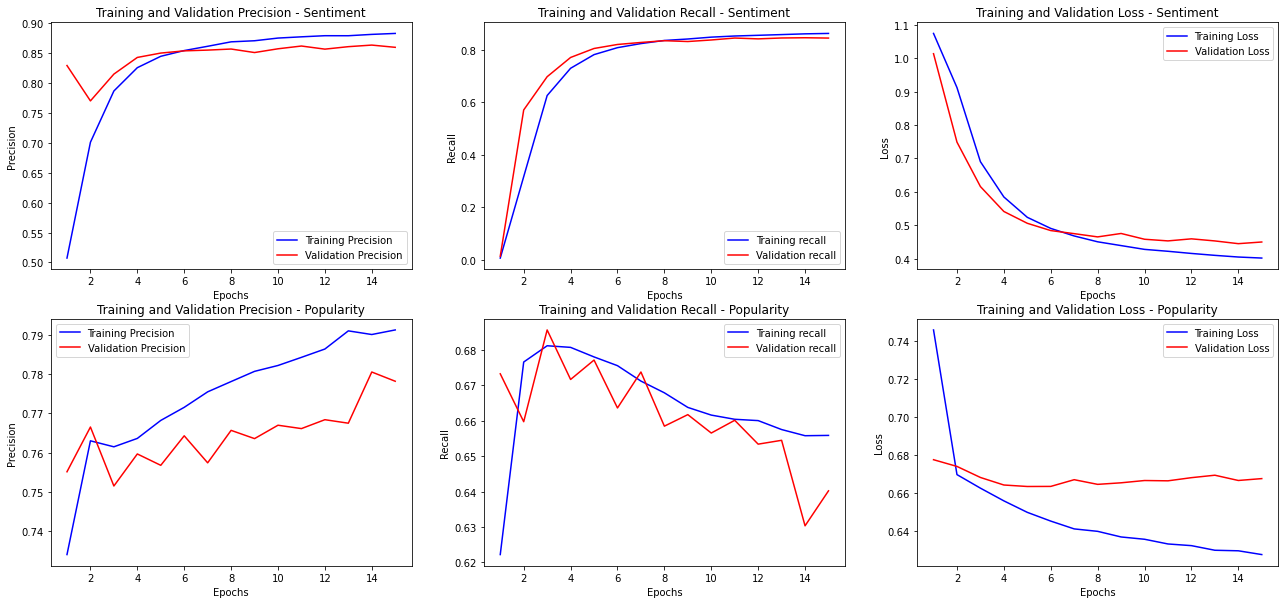

In [65]:
show_perfromances(gru_history_drop1)

In [66]:
evaluate_model(gru_model_drop1, padded_inputs_test, one_hot_test_labels_sentiment, one_hot_test_labels_popularity)

547/547 [==============================] - 6s 7ms/step - loss: 2.7202 - sentiment_loss: 0.4499 - popularity_loss: 2.2703 - sentiment_precision: 0.8598 - sentiment_recall: 0.8439 - popularity_precision_1: 0.2088 - popularity_recall_1: 0.1718

Sentiment prediction, performance on validation data:
model precision: 85.98%
model recall : 84.39% 
model loss: 44.99%

547/547 [==============================] - 4s 6ms/step - loss: 3.2881 - sentiment_loss: 2.6206 - popularity_loss: 0.6675 - sentiment_precision: 0.2463 - sentiment_recall: 0.2418 - popularity_precision_1: 0.7782 - popularity_recall_1: 0.6402

Popularity prediction, performance on validation data:
model precision: 77.82%
model recall : 64.02% 
model loss: 66.75%


In [67]:
gru_history_drop2 = gru_model_drop2.fit(padded_inputs, 
                         [one_hot_train_labels_sentiment, one_hot_train_labels_popularity],
                          batch_size=512, 
                          epochs=15, 
                          verbose=0, 
                          validation_data=(padded_inputs_test, [one_hot_test_labels_sentiment,one_hot_test_labels_popularity]))

Final model loss on validation data: 114.0%


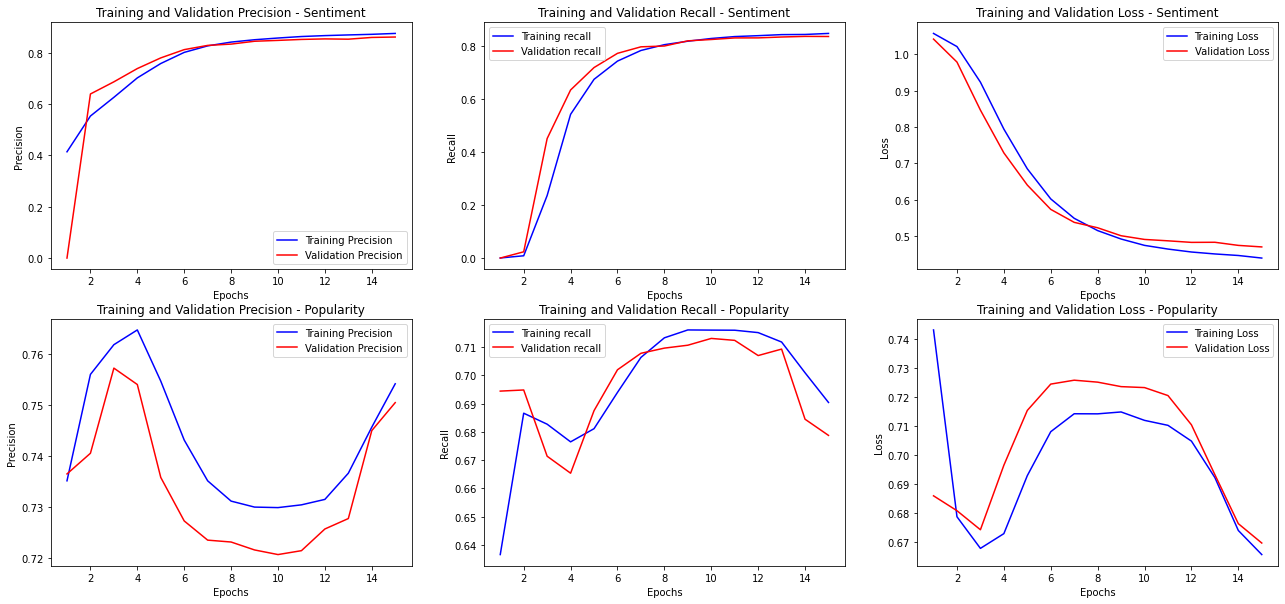

In [68]:
show_perfromances(gru_history_drop2)

In [69]:
evaluate_model(gru_model_drop2, padded_inputs_test, one_hot_test_labels_sentiment, one_hot_test_labels_popularity)

547/547 [==============================] - 4s 6ms/step - loss: 2.4942 - sentiment_loss: 0.4705 - popularity_loss: 2.0237 - sentiment_precision: 0.8607 - sentiment_recall: 0.8374 - popularity_precision_1: 0.1950 - popularity_recall_1: 0.1764

Sentiment prediction, performance on validation data:
model precision: 86.07%
model recall : 83.74% 
model loss: 47.05%

547/547 [==============================] - 3s 6ms/step - loss: 3.1289 - sentiment_loss: 2.4594 - popularity_loss: 0.6695 - sentiment_precision: 0.2445 - sentiment_recall: 0.2379 - popularity_precision_1: 0.7504 - popularity_recall_1: 0.6787

Popularity prediction, performance on validation data:
model precision: 75.04%
model recall : 67.87% 
model loss: 66.95%


In [70]:
gru_history_drop3 = gru_model_drop3.fit(padded_inputs, 
                         [one_hot_train_labels_sentiment, one_hot_train_labels_popularity],
                          batch_size=512, 
                          epochs=15, 
                          verbose=0, 
                          validation_data=(padded_inputs_test, [one_hot_test_labels_sentiment,one_hot_test_labels_popularity]))

Final model loss on validation data: 113.17%


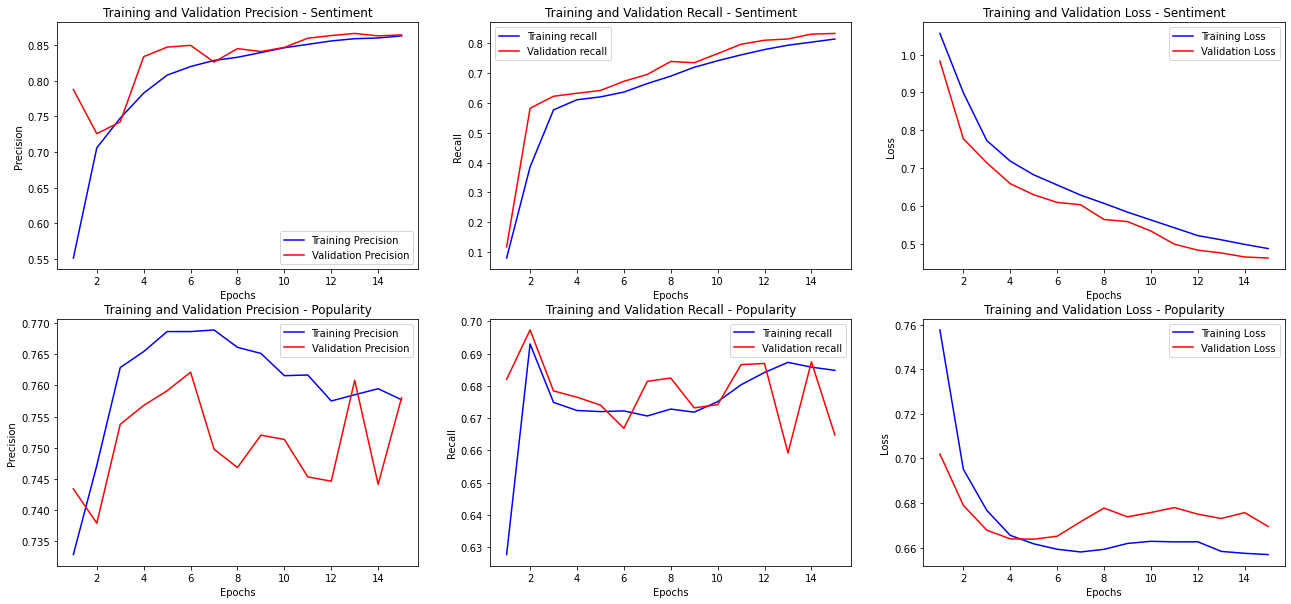

In [71]:
show_perfromances(gru_history_drop3)

In [72]:
evaluate_model(gru_model_drop3, padded_inputs_test, one_hot_test_labels_sentiment, one_hot_test_labels_popularity)

547/547 [==============================] - 4s 6ms/step - loss: 2.5165 - sentiment_loss: 0.4622 - popularity_loss: 2.0543 - sentiment_precision: 0.8639 - sentiment_recall: 0.8326 - popularity_precision_1: 0.1990 - popularity_recall_1: 0.1745

Sentiment prediction, performance on validation data:
model precision: 86.39%
model recall : 83.26% 
model loss: 46.22%

547/547 [==============================] - 3s 6ms/step - loss: 3.1032 - sentiment_loss: 2.4337 - popularity_loss: 0.6695 - sentiment_precision: 0.2539 - sentiment_recall: 0.2448 - popularity_precision_1: 0.7580 - popularity_recall_1: 0.6648

Popularity prediction, performance on validation data:
model precision: 75.8%
model recall : 66.48% 
model loss: 66.95%


**Dropout of 0.2 works well and reduces overfitting as compared to the original GRU model**

### **Find Optimal Training Epochs for Final model**

**Next I create the final model and train it for a longer amount of epochs to find when it starts to overfit, if at all. For the final model I use a combination of all the previous hyperparameters, I add L2 and dropout regularisation and I reduce the embedding output dimensions to 16.**  

In [73]:
embedding_output_dims = 16
def create_gru_model_longer(NUM_WORDS,embedding_output_dims,l2_rate,dropout_rate):
    main_input = Input(shape=(None,), dtype='int32', name='news_input')
    x = Embedding(NUM_WORDS, embedding_output_dims, input_length=max_sequence_length, embeddings_regularizer = l2(l2_rate)) (main_input)
    x = Dropout(dropout_rate) (x)
    x = GRU(16, return_sequences=True, kernel_regularizer=regularizers.l2(l2_rate)) (x)
    x = Dropout(dropout_rate) (x)
    x = GRU(16) (x) 
    x = Dropout(dropout_rate) (x)
    x = Dense(8, activation='relu')(x)
    sentiment_predcition = Dense(3, activation='softmax', name="sentiment")(x)
    popularity_prediction = Dense(3, activation='softmax', name="popularity")(x)

    model = Model(inputs=main_input, outputs=[sentiment_predcition, popularity_prediction], name = "gru_network")
    model.compile(optimizer="rmsprop",
              loss={"sentiment":"categorical_crossentropy", "popularity":"categorical_crossentropy"},
              metrics=["Precision", "Recall"])
    return model

gru_model_longer = create_gru_model_longer(NUM_WORDS, 16, 0.00001, 0.2)

In [74]:
gru_history_longer = gru_model_longer.fit(padded_inputs, 
                         [one_hot_train_labels_sentiment, one_hot_train_labels_popularity],
                          batch_size=512, 
                          epochs=30, 
                          verbose=0, 
                          validation_data=(padded_inputs_test, [one_hot_test_labels_sentiment,one_hot_test_labels_popularity]))

Final model loss on validation data: 104.89%


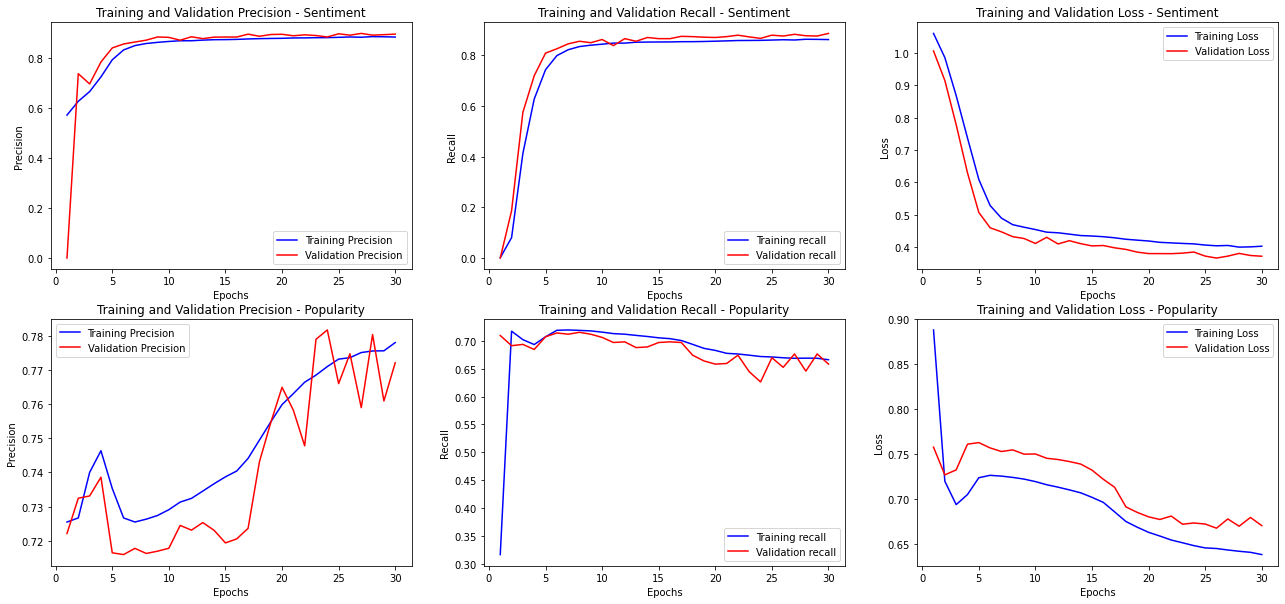

In [75]:
show_perfromances(gru_history_longer)

In [76]:
evaluate_model(gru_model_longer, padded_inputs_test, one_hot_test_labels_sentiment, one_hot_test_labels_popularity)

28/28 [==============================] - 1s 6ms/step - loss: 2.5552 - sentiment_loss: 0.3720 - popularity_loss: 2.1768 - sentiment_precision: 0.8960 - sentiment_recall: 0.8857 - popularity_precision_1: 0.1903 - popularity_recall_1: 0.1623

Sentiment prediction, performance on validation data:
model precision: 89.6%
model recall : 88.57% 
model loss: 37.2%

28/28 [==============================] - 0s 6ms/step - loss: 3.1162 - sentiment_loss: 2.4393 - popularity_loss: 0.6705 - sentiment_precision: 0.2566 - sentiment_recall: 0.2537 - popularity_precision_1: 0.7721 - popularity_recall_1: 0.6583

Popularity prediction, performance on validation data:
model precision: 77.21%
model recall : 65.83% 
model loss: 67.05%


Final model loss on validation data: 104.89%


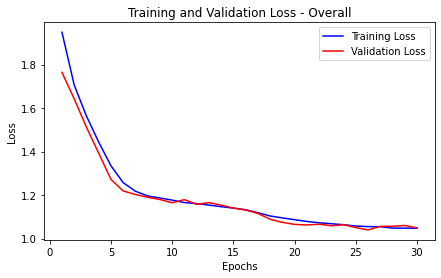

In [77]:
fig, ax1 = plt.subplots(nrows=1, ncols=1)
#fig.set_size_inches(24,5
fig.set_size_inches(7,4)
plot_perfromance(gru_history_longer.history["loss"], gru_history_longer.history["val_loss"],"loss",ax1, "Overall")
final_loss = gru_history_longer.history["val_loss"][len(gru_history_longer.history["val_loss"])-1] 
print("Final model loss on validation data:", str(round(final_loss* 100,2)) + "%")

**We can see that  by the 20th epoch the model's training loss decreases to a point of stability, therefore there is no need to train it for longer that 20 epochs.** 

### **Train final model**

**Below I train the final model for the optional amount of time.**  

In [78]:
embedding_output_dims = 16
def create_gru_model_final(NUM_WORDS,embedding_output_dims,l2_rate,dropout_rate):
    main_input = Input(shape=(None,), dtype='int32', name='news_input')
    x = Embedding(NUM_WORDS, embedding_output_dims, input_length=max_sequence_length, embeddings_regularizer = l2(l2_rate)) (main_input)
    x = Dropout(dropout_rate) (x)
    x = GRU(16, return_sequences=True, kernel_regularizer=regularizers.l2(l2_rate)) (x)
    x = Dropout(dropout_rate) (x)
    x = GRU(16) (x) 
    x = Dropout(dropout_rate) (x)
    x = Dense(8, activation='relu')(x)
    sentiment_predcition = Dense(3, activation='softmax', name="sentiment")(x)
    popularity_prediction = Dense(3, activation='softmax', name="popularity")(x)

    model = Model(inputs=main_input, outputs=[sentiment_predcition, popularity_prediction], name = "lstm_network")
    model.compile(optimizer="rmsprop",
              loss={"sentiment":"categorical_crossentropy", "popularity":"categorical_crossentropy"},
              metrics=["Precision", "Recall"])
    return model

gru_model_final = create_gru_model_final(NUM_WORDS,16, 0.00001, 0.2) 

**For the final model I use 99% of the data for training and only 1% for testing.**

In [79]:
train_data, test_data, train_labels, test_labels = train_test_split(df["Title"], df[["SentimentTitle", "Popularity"]], test_size=0.01)
tokenizer.fit_on_texts(train_data)

train_data_seq = tokenizer.texts_to_sequences(train_data)
test_data_seq = tokenizer.texts_to_sequences(test_data)

padded_inputs = pad_sequences(train_data_seq, maxlen=max_sequence_length, value = 0.0) # 0.0 because it corresponds with <PAD>
padded_inputs_test = pad_sequences(test_data_seq, maxlen=max_sequence_length, value = 0.0) # 0.0 because it corresponds with <PAD>

le = LabelEncoder()

train_labels_le_sentiment = le.fit_transform(train_labels["SentimentTitle"])
test_labels_le_sentiment  = le.transform(test_labels["SentimentTitle"])
one_hot_train_labels_sentiment = to_categorical(train_labels_le_sentiment)
one_hot_test_labels_sentiment  = to_categorical(test_labels_le_sentiment)

train_labels_le_poplarity = le.fit_transform(train_labels["Popularity"])
test_labels_le_popularity = le.transform(test_labels["Popularity"])
one_hot_train_labels_popularity = to_categorical(train_labels_le_poplarity)
one_hot_test_labels_popularity = to_categorical(test_labels_le_popularity)

In [80]:
gru_history_final = gru_model_final.fit(padded_inputs, 
                         [one_hot_train_labels_sentiment, one_hot_train_labels_popularity],
                          batch_size=512, 
                          epochs=20, 
                          verbose=1,
                          validation_data=(padded_inputs_test, [one_hot_test_labels_sentiment,one_hot_test_labels_popularity]))           

Epoch 1/20
170/170 [==============================] - 15s 88ms/step - loss: 1.6211 - sentiment_loss: 0.9145 - popularity_loss: 0.7013 - sentiment_precision: 0.6415 - sentiment_recall: 0.5116 - popularity_precision_1: 0.7495 - popularity_recall_1: 0.6642 - val_loss: 1.4934 - val_sentiment_loss: 0.8132 - val_popularity_loss: 0.6750 - val_sentiment_precision: 0.6900 - val_sentiment_recall: 0.5977 - val_popularity_precision_1: 0.7380 - val_popularity_recall_1: 0.7051
Epoch 2/20
170/170 [==============================] - 15s 87ms/step - loss: 1.4076 - sentiment_loss: 0.7263 - popularity_loss: 0.6760 - sentiment_precision: 0.7389 - sentiment_recall: 0.6499 - popularity_precision_1: 0.7472 - popularity_recall_1: 0.6875 - val_loss: 1.3299 - val_sentiment_loss: 0.6567 - val_popularity_loss: 0.6679 - val_sentiment_precision: 0.7750 - val_sentiment_recall: 0.7086 - val_popularity_precision_1: 0.7522 - val_popularity_recall_1: 0.6937
Epoch 3/20
170/170 [==============================] - 15s 87ms/s

## **Final Model Evaluation**

### **Baseline**

**To evaluate the model I first establish a statistical baseline, which in this case is the ZeroR calculation for both the sentiment and popularity variables in this case.**

In [81]:
sentiment_baseline = ((35493/87495)**2 + (34382/87495)**2 + (17620/87495)**2)*100
print("Baseline check sentiment :",round(sentiment_baseline,1),"%")
popularity_baseline = ((63336/87495)**2 + (19025/87495)**2 + (5134/87495)**2)*100
print("Baseline check popularity:", round(popularity_baseline,1),"%")

Baseline check sentiment : 36.0 %
Baseline check popularity: 57.5 %


**The final model needs performance better than 36% and 57.5% for the sentiment and popularity respectively on the precision metric to prove that it has statistical power over a random selection from the dataset and is in fact useful.** 

**Dummy classifiers confirm the same baseline performance (precision - weighted avg) that needs to be beat.**

In [82]:
# build a dummy classifer for sentiment
dummy_clf = DummyClassifier(strategy="uniform")
dummy_clf.fit(padded_inputs, one_hot_train_labels_sentiment)
y_pred_dummy_s = dummy_clf.predict(padded_inputs_test)

# build a dummy classifer for popularity
dummy_clf = DummyClassifier(strategy="uniform")
dummy_clf.fit(padded_inputs, one_hot_train_labels_popularity)
y_pred_dummy_p = dummy_clf.predict(padded_inputs_test)

print("Dummy Classifier Sentiment Performance:")
print(classification_report(one_hot_test_labels_sentiment,y_pred_dummy_s))
print("Dummy Classifier Popularity Performance:")
print(classification_report(one_hot_test_labels_popularity,y_pred_dummy_p))

Dummy Classifier Sentiment Performance:
              precision    recall  f1-score   support

           0       0.40      0.51      0.45       342
           1       0.21      0.49      0.29       183
           2       0.40      0.50      0.45       350

   micro avg       0.34      0.51      0.41       875
   macro avg       0.34      0.50      0.40       875
weighted avg       0.36      0.51      0.42       875
 samples avg       0.30      0.51      0.36       875

Dummy Classifier Popularity Performance:
              precision    recall  f1-score   support

           0       0.22      0.49      0.31       196
           1       0.70      0.49      0.58       631
           2       0.05      0.48      0.09        48

   micro avg       0.32      0.49      0.39       875
   macro avg       0.32      0.49      0.32       875
weighted avg       0.56      0.49      0.49       875
 samples avg       0.28      0.49      0.34       875



Final model loss on validation data: 103.56%


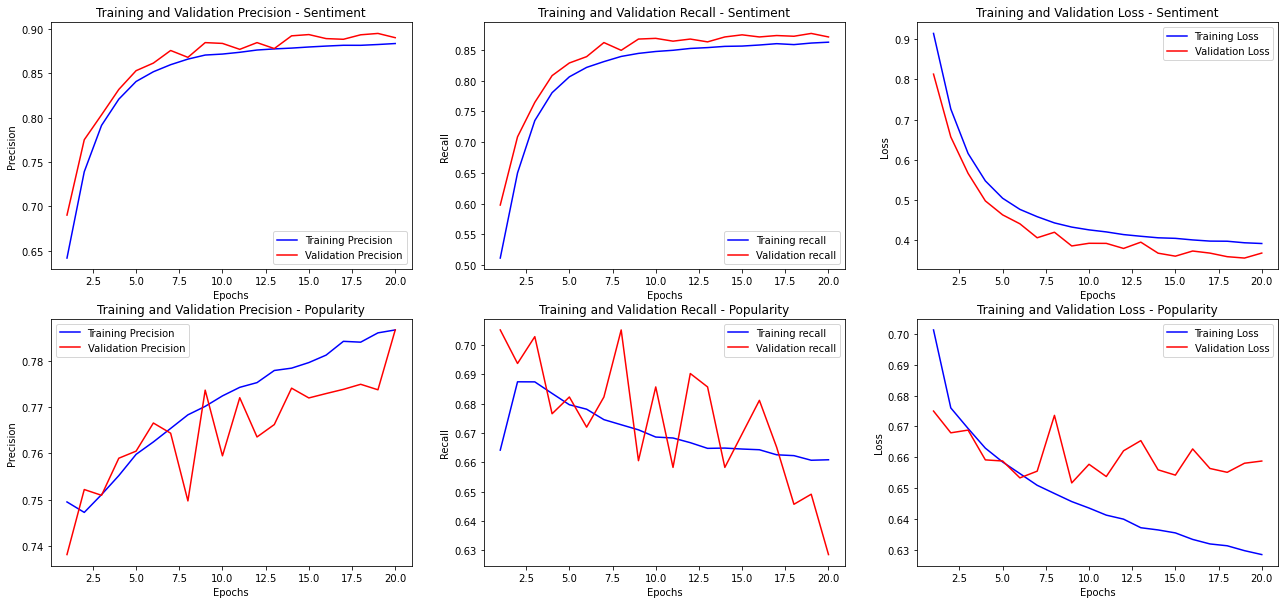

In [83]:
show_perfromances(gru_history_final)

In [38]:
evaluate_model(gru_model_final, padded_inputs_test, one_hot_test_labels_sentiment, one_hot_test_labels_popularity)

28/28 [==============================] - 0s 10ms/step - loss: 2.5163 - sentiment_loss: 0.3676 - popularity_loss: 2.1395 - sentiment_precision: 0.8902 - sentiment_recall: 0.8709 - popularity_precision_1: 0.2203 - popularity_recall_1: 0.1760

Sentiment prediction, performance on validation data:
model precision: 89.02%
model recall : 87.09% 
model loss: 36.76%

28/28 [==============================] - 0s 8ms/step - loss: 3.1233 - sentiment_loss: 2.4553 - popularity_loss: 0.6588 - sentiment_precision: 0.2804 - sentiment_recall: 0.2743 - popularity_precision_1: 0.7868 - popularity_recall_1: 0.6286

Popularity prediction, performance on validation data:
model precision: 78.68%
model recall : 62.86% 
model loss: 65.88%


**We can observe the final model’s overall loss.**

Final model loss on validation data: 103.56%


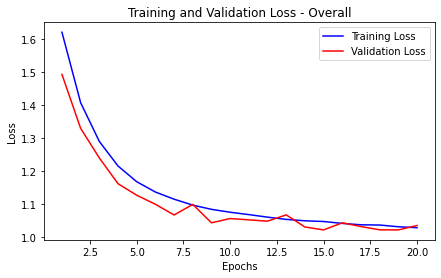

In [84]:
fig, ax1 = plt.subplots(nrows=1, ncols=1)
#fig.set_size_inches(24,5
fig.set_size_inches(7,4)
plot_perfromance(gru_history_final.history["loss"], gru_history_final.history["val_loss"],"loss",ax1, "Overall")
final_loss = gru_history_final.history["val_loss"][len(gru_history_final.history["val_loss"])-1] 
print("Final model loss on validation data:", str(round(final_loss* 100,2)) + "%")

**Let's see some predictions**

In [85]:
predictions = gru_model_final.predict(padded_inputs_test)
print("index","\t\t","prediction(Sent.)","\t","actual(Sent.)","\t\t","prediction(Pop.)","\t","actual(Pop.)")
count_sent = 0
count_pop = 0
for i in range(20):
    if np.argmax(predictions[0][i]) == test_labels_le_sentiment[i]:
        count_sent += 1
    if np.argmax(predictions[1][i]) == test_labels_le_popularity[i]:
        count_pop += 1
    print(i, "\t\t", np.argmax(predictions[0][i]) ,"\t\t\t",test_labels_le_sentiment[i], "\t\t\t",np.argmax(predictions[1][i]) ,"\t\t\t",test_labels_le_popularity[i])
print("number of correct predictions on sentiment label:",count_sent)
print("number of correct predictions on popularity label count:",count_pop)

28/28 [==============================] - 1s 8ms/step
index 		 prediction(Sent.) 	 actual(Sent.) 		 prediction(Pop.) 	 actual(Pop.)
0 		 2 			 2 			 1 			 1
1 		 2 			 2 			 1 			 1
2 		 0 			 0 			 1 			 1
3 		 1 			 1 			 1 			 1
4 		 2 			 2 			 1 			 1
5 		 0 			 0 			 1 			 1
6 		 2 			 2 			 1 			 1
7 		 2 			 0 			 1 			 1
8 		 0 			 0 			 1 			 0
9 		 1 			 1 			 1 			 1
10 		 0 			 0 			 1 			 1
11 		 0 			 0 			 1 			 1
12 		 2 			 0 			 0 			 0
13 		 0 			 0 			 0 			 2
14 		 0 			 0 			 1 			 1
15 		 0 			 0 			 1 			 1
16 		 0 			 0 			 1 			 0
17 		 2 			 2 			 1 			 1
18 		 0 			 0 			 1 			 1
19 		 2 			 2 			 1 			 1
number of correct predictions on sentiment label: 18
number of correct predictions on popularity label count: 17


In [86]:
#tf.keras.utils.plot_model(gru_model, show_shapes=True)

###  **Evaluation summary**

**Overall the final model's performance is satisfactory. It performs significantly better than the baseline calculations and dummy classifier on the precision and recall metrics indicating that it has significant statistical power as compared to them and can generalise well. In addition, based on these results, we can conclude that the model solved the core prediction problem of this project quite well.**